## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

# id (string) - offer id
# offer_type (string) - type of offer ie BOGO, discount, informational
# difficulty (int) - minimum required spend to complete an offer
# reward (int) - reward given for completing an offer
# duration (int) - time for offer to be open, in days
# channels (list of strings)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
profile.head()

# age (int) - age of the customer
# became_member_on (int) - date when customer created an app account
# gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
# id (str) - customer id
# income (float) - customer's income

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [5]:
profile.isnull().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

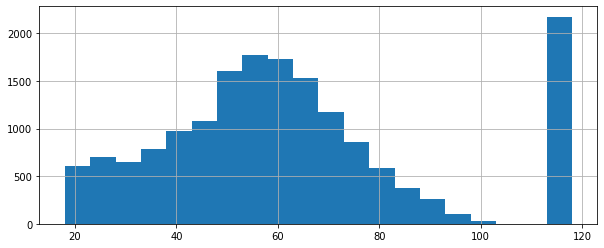

In [6]:
profile.age.hist(bins=20, figsize=(10,4))

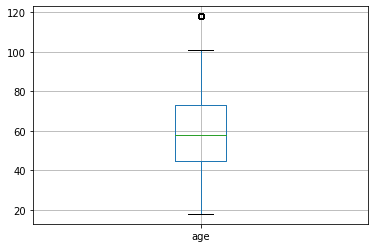

In [7]:
profile.boxplot(column=['age'])

In [8]:
profile[profile.age > 90].age.value_counts()

118    2175
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, dtype: int64

In [9]:
profile[profile.age > 90].gender.isnull().mean()

0.9085213032581454

In [10]:
profile[profile.age > 90].became_member_on.nunique()

993

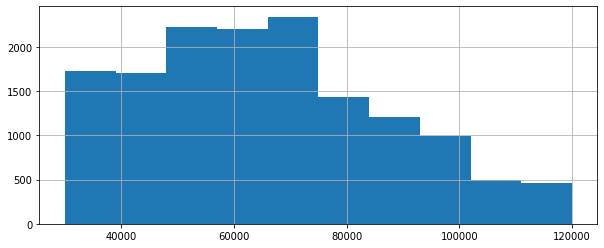

In [11]:
profile.income.hist(bins=10, figsize=(10,4))

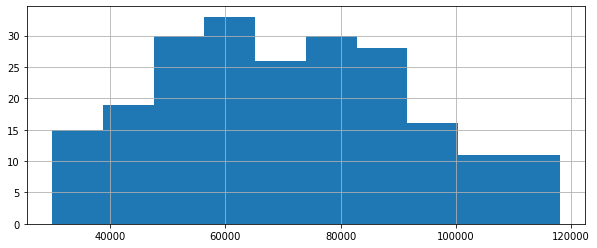

In [12]:
profile[profile.age > 90].income.hist(bins=10, figsize=(10,4))

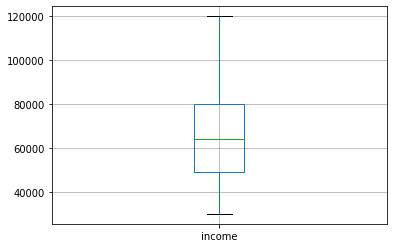

In [13]:
profile.boxplot(column=['income'])

In [14]:
transcript.head()

# event (str) - record description (ie transaction, offer received, offer viewed, etc.)
# person (str) - customer id
# time (int) - time in hours since start of test. The data begins at time t=0
# value - (dict of strings) - either an offer id or transaction amount depending on the record

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

## Data Views

* Transactional view - how many transactions used offers 
    * viewed offer used
    * not viewed offer used
* Customer view - who are using the offers more frequently?
    * Transactional view can be used to answer this question.



## Create New Transcript DF

In [178]:
# create offer_id and amount columns
df_transcript = transcript.copy()
df_transcript['value_flat'] = df_transcript['value'].apply(lambda x: list(x.items())[0][1])
df_transcript = df_transcript.rename(columns={'person': 'customer_id'}).drop(columns=['value'])
df_transcript.head()

,customer_id,event,time,value_flat
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


## DF Transactions

In [180]:
import uuid

rename_columns={'time':'transaction_time', 'value_flat':'transaction_amount'}

# create dataframe with only transaction events
df_transactions = df_transcript[df_transcript['event']=='transaction'].rename(columns=rename_columns)

# convert transaction_amount into float
df_transactions['transaction_amount'] = df_transactions['transaction_amount'].apply(lambda x: float(x))

# create transaction_id and drop event column 
transaction_ids = []
n = len(df_transactions)
for _ in range(n):
    _id = uuid.uuid4().hex
    transaction_ids.append(_id)

# add transaction_id as first column in df
df_transactions.insert(loc=0, column='transaction_id', value=transaction_ids)
df_transactions.drop(columns=['event'], inplace=True)

df_transactions.head()

,transaction_id,customer_id,transaction_time,transaction_amount
12654,517124168729478bb3a757a9889aa37d,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,d0d264fde45f489a803522437a79d5cd,54890f68699049c2a04d415abc25e717,0,13.23
12670,e78dad3ffb574cb792714f01e8de810b,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,d871a5c432f64c7bbe7b25c16e2a90a0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [72]:
df_transactions.shape

(138953, 4)

In [73]:
df_transactions.describe()

,transaction_time,transaction_amount
count,138953.000000,138953.000000
mean,381.584334,12.777356
std,201.697230,30.250529
min,0.000000,0.050000
25%,210.000000,2.780000
50%,402.000000,8.890000
75%,552.000000,18.070000
max,714.000000,1062.280000


## DF Offer Completed

In [181]:
rename_columns={'time':'offer_completed_time', 'value_flat':'offer_id'}

df_completed = df_transcript[df_transcript['event']=='offer completed'].rename(columns=rename_columns)

df_completed.insert(loc=1, column='offer_completed', value=1)

df_completed.drop(columns=['event'], inplace=True)

df_completed.head()

,customer_id,offer_completed,offer_completed_time,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,1,0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,1,0,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [272]:
df_completed.shape

(33579, 4)

## DF Engagement: DF Transactions + DF Offer Completed

In [338]:
df_engagement = pd.merge(df_transactions, 
                         df_completed, 
                         how='left', 
                         left_on=['customer_id','transaction_time'],
                         right_on=['customer_id','offer_completed_time'],
                         suffixes=['','_drop'])

df_engagement['offer_completed'] = df_engagement['offer_completed'].fillna(0).astype(int)
df_engagement['offer_completed_time'] = df_engagement['offer_completed_time'].fillna(-1).astype(int)
df_engagement['offer_id'] = df_engagement['offer_id'].fillna('no-offer')

# create record_id to track number of unique records/rows per transaction_id
record_ids = []
n = len(df_engagement)
for _ in range(n):
    _id = uuid.uuid4().hex
    record_ids.append(_id)

df_engagement.insert(loc=0, column='record_id', value=record_ids)


In [339]:
df_engagement.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id
0,28e8cac0fb464d59b8de3fa440948fcc,517124168729478bb3a757a9889aa37d,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer
1,b1471414dde44e839deaa437dd34622b,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5
2,7ced4571e5db4d809d330c928c8859da,d0d264fde45f489a803522437a79d5cd,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer
3,8680cd8975bf426f97b8c58fb5823a37,e78dad3ffb574cb792714f01e8de810b,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer
4,b38b7da59a4f4f809b51677cee206042,d871a5c432f64c7bbe7b25c16e2a90a0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4


In [342]:
df_engagement.offer_completed.sum()

33579

In [343]:
df_engagement[df_engagement['transaction_id']=='0799802c7c3040a1b715bafa4b59cd34']

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id
111768,dcc2a3279f8e44f1857f4b6be460d3e7,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,fafdcd668e3743c1bb461111dcafc2a4
111769,0062b9b8a6264ca0ad4f7258cdf03764,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,fafdcd668e3743c1bb461111dcafc2a4
111770,e2dc35d22fb54b189fc1e643448fd94a,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,f19421c1d4aa40978ebb69ca19b0e20d


In [344]:
df_transcript[df_transcript['customer_id']=='6c5e611cd1284709b634ff1740d13265']

,customer_id,event,time,value_flat
12230,6c5e611cd1284709b634ff1740d13265,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
33991,6c5e611cd1284709b634ff1740d13265,transaction,60,0.7
65444,6c5e611cd1284709b634ff1740d13265,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2
77142,6c5e611cd1284709b634ff1740d13265,offer viewed,186,2298d6c36e964ae4a3e7e9706d1fb8c2
103803,6c5e611cd1284709b634ff1740d13265,transaction,288,2.22
123106,6c5e611cd1284709b634ff1740d13265,offer received,336,fafdcd668e3743c1bb461111dcafc2a4
132736,6c5e611cd1284709b634ff1740d13265,offer viewed,348,fafdcd668e3743c1bb461111dcafc2a4
148864,6c5e611cd1284709b634ff1740d13265,transaction,396,3.92
162935,6c5e611cd1284709b634ff1740d13265,offer received,408,fafdcd668e3743c1bb461111dcafc2a4
174259,6c5e611cd1284709b634ff1740d13265,offer viewed,420,fafdcd668e3743c1bb461111dcafc2a4


## Identify DF Received Offer Converted Transactions

In [310]:
rename_columns = {'event': 'offer_received', 'value_flat': 'offer_id', 'time': 'offer_received_time'}

df_received = df_transcript[df_transcript['event']=='offer received'].rename(columns=rename_columns)

df_received['offer_received'] = df_received['offer_received'].apply(lambda x: 1 if not pd.isnull(x) else 0)

df_received.head()

,customer_id,offer_received,offer_received_time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,1,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,1,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [409]:
df_received_converted = pd.merge(df_engagement, df_received, how='inner', on=['customer_id', 'offer_id'])

df_received_converted['tt-rt'] = df_received_converted['transaction_time'] - df_received_converted['offer_received_time']

df_received_converted = df_received_converted[df_received_converted['tt-rt'] >= 0]

df_received_converted.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time,tt-rt
0,b1471414dde44e839deaa437dd34622b,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0,0
1,b38b7da59a4f4f809b51677cee206042,d871a5c432f64c7bbe7b25c16e2a90a0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0
2,46c18d6b949f454d939802ce76aa4825,180cfbb9a5804d7b95d7d0332c6130b4,629fc02d56414d91bca360decdfa9288,0,33.90,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
3,4830478330804d29b5d1b9eebe512ff5,bfcba7e1043f44938df442c4e7bc1739,676506bad68e4161b9bbaffeb039626b,0,18.01,1,0,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
4,e2dcbc37d1064268abb3990e5f042067,0feb6adc76de4f3980e1c4966dcacf55,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,19.11,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0


In [410]:
df_received_converted.offer_completed.sum()

40488

In [347]:
df_received_converted[df_received_converted['transaction_id']=='0799802c7c3040a1b715bafa4b59cd34']

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time,tt-rt
39836,dcc2a3279f8e44f1857f4b6be460d3e7,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,fafdcd668e3743c1bb461111dcafc2a4,1,336,240
39837,dcc2a3279f8e44f1857f4b6be460d3e7,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,fafdcd668e3743c1bb461111dcafc2a4,1,408,168
39838,0062b9b8a6264ca0ad4f7258cdf03764,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,fafdcd668e3743c1bb461111dcafc2a4,1,336,240
39839,0062b9b8a6264ca0ad4f7258cdf03764,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,fafdcd668e3743c1bb461111dcafc2a4,1,408,168
39840,e2dc35d22fb54b189fc1e643448fd94a,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,f19421c1d4aa40978ebb69ca19b0e20d,1,504,72


In [348]:
# offer_viewed_time column not included
# transaction_time and offer_completed_time same values
df_rc_min = df_received_converted.groupby(['record_id','transaction_id','customer_id',
                                       'transaction_time','transaction_amount',
                                       'offer_completed','offer_completed_time',
                                       'offer_id','offer_received'])['tt-rt'].min().reset_index()

In [349]:
df_rc_min[df_rc_min['transaction_id']=='0799802c7c3040a1b715bafa4b59cd34']

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,tt-rt
57,0062b9b8a6264ca0ad4f7258cdf03764,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,fafdcd668e3743c1bb461111dcafc2a4,1,168
28846,dcc2a3279f8e44f1857f4b6be460d3e7,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,fafdcd668e3743c1bb461111dcafc2a4,1,168
29673,e2dc35d22fb54b189fc1e643448fd94a,0799802c7c3040a1b715bafa4b59cd34,6c5e611cd1284709b634ff1740d13265,576,8.82,1,576,f19421c1d4aa40978ebb69ca19b0e20d,1,72


In [350]:
df_rc_min.offer_completed.sum()

33579

In [351]:
df_received_mapped = df_rc_min.copy()
df_received_mapped['offer_received_time'] = df_received_mapped['transaction_time'] - df_received_mapped['tt-rt']
df_received_mapped.drop(columns=['tt-rt'], inplace=True)
df_received_mapped.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time
0,000087b3666d459d8be0df98cbc34ef7,be723873b5c04203a6f2a0dc835a92e5,99148a450059428180ed37cb9ab01f62,642,10.70,1,642,2906b810c7d4411798c6938adc9daaa5,1,576
1,00016e20bda045f2a2f42fa2c5853b8b,7b00a08994ad47b0b4e04b913d939c75,a7aca0114d2145a687d726e9d6f35b83,36,11.66,1,36,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0
2,0002dc5b50844502a94a9c366ad5b249,878ca3a22a0d49a683fb6d87c067228d,2349cf9c53bb49e09b23e4684cdcd86a,432,15.43,1,432,f19421c1d4aa40978ebb69ca19b0e20d,1,408
3,000543d780584d51833f18af504c1bf4,fc880930e7a34f3f81bc9188966ecd4a,6597e5ab63754726b83ba2032f008d26,222,21.43,1,222,f19421c1d4aa40978ebb69ca19b0e20d,1,168
4,00059178d98c42519ff2c24a3c32497b,f1f51c6eeeac4f9cb20fbc929bc24687,4b9a3bf77bb64f4ca41e314aa24fc36a,588,16.47,1,588,2298d6c36e964ae4a3e7e9706d1fb8c2,1,576


## Merge df_engagement with df_received_mapped

In [352]:
df_engagement.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id
0,28e8cac0fb464d59b8de3fa440948fcc,517124168729478bb3a757a9889aa37d,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer
1,b1471414dde44e839deaa437dd34622b,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5
2,7ced4571e5db4d809d330c928c8859da,d0d264fde45f489a803522437a79d5cd,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer
3,8680cd8975bf426f97b8c58fb5823a37,e78dad3ffb574cb792714f01e8de810b,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer
4,b38b7da59a4f4f809b51677cee206042,d871a5c432f64c7bbe7b25c16e2a90a0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4


In [354]:
# merge offer_received and offer_received_time columns to df_engagement where it's a match with record_id

df_received_mapped_v2 = df_received_mapped[['record_id', 'offer_received', 'offer_received_time']] 

df_engagement_v2 = pd.merge(df_engagement,
                            df_received_mapped_v2,
                            how='left',
                            on='record_id')

df_engagement_v2['offer_received'] = df_engagement_v2['offer_received'].fillna(0).astype(int)
df_engagement_v2['offer_received_time'] = df_engagement_v2['offer_received_time'].fillna(-1).astype(int)

df_engagement_v2.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time
0,28e8cac0fb464d59b8de3fa440948fcc,517124168729478bb3a757a9889aa37d,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer,0,-1
1,b1471414dde44e839deaa437dd34622b,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0
2,7ced4571e5db4d809d330c928c8859da,d0d264fde45f489a803522437a79d5cd,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer,0,-1
3,8680cd8975bf426f97b8c58fb5823a37,e78dad3ffb574cb792714f01e8de810b,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer,0,-1
4,b38b7da59a4f4f809b51677cee206042,d871a5c432f64c7bbe7b25c16e2a90a0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,0


In [355]:
df_engagement_v2.offer_received.sum()

33579

## Merge df_engagement_v2 with df_viewed_mapped

* When a transaction has __two or more same offer completed__, only the most recent offer will be mapped. This will serve as a proxy when two or more same offer deals are completed in a single transaction. 
* A transaction with completed offers, an offer is considered viewed with a offer_viewed when offer_viewed_time falls between offer_completed_time and offer_received_time. 



__Example:__ 
```python
df_transcript[df_transcript['customer_id']=='6c5e611cd1284709b634ff1740d13265']
```


In [356]:
rename_columns = {'event': 'offer_viewed', 'value_flat': 'offer_id', 'time': 'offer_viewed_time'}

df_viewed = df_transcript[df_transcript['event']=='offer viewed'].rename(columns=rename_columns)

df_viewed['offer_viewed'] = df_viewed['offer_viewed'].apply(lambda x: 1 if not pd.isnull(x) else 0)

df_viewed.head()

,customer_id,offer_viewed,offer_viewed_time,offer_id
12650,389bc3fa690240e798340f5a15918d5c,1,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,1,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,1,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,1,0,5a8bc65990b245e5a138643cd4eb9837


In [358]:
df_engagement_v2.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time
0,28e8cac0fb464d59b8de3fa440948fcc,517124168729478bb3a757a9889aa37d,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer,0,-1
1,b1471414dde44e839deaa437dd34622b,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0
2,7ced4571e5db4d809d330c928c8859da,d0d264fde45f489a803522437a79d5cd,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer,0,-1
3,8680cd8975bf426f97b8c58fb5823a37,e78dad3ffb574cb792714f01e8de810b,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer,0,-1
4,b38b7da59a4f4f809b51677cee206042,d871a5c432f64c7bbe7b25c16e2a90a0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,0


In [362]:
df_viewed_converted = pd.merge(df_engagement_v2, df_viewed, how='inner', on=['customer_id', 'offer_id'])

df_viewed_converted = df_viewed_converted[(df_viewed_converted['offer_id'] != 'no-offer')
                                           & (df_viewed_converted['transaction_time'] >= df_viewed_converted['offer_viewed_time'])
                                           & (df_viewed_converted['offer_viewed_time'] >= df_viewed_converted['offer_received_time'])]

df_viewed_converted.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time,offer_viewed,offer_viewed_time
0,b1471414dde44e839deaa437dd34622b,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0,1,0
2,46c18d6b949f454d939802ce76aa4825,180cfbb9a5804d7b95d7d0332c6130b4,629fc02d56414d91bca360decdfa9288,0,33.90,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,0
3,4830478330804d29b5d1b9eebe512ff5,bfcba7e1043f44938df442c4e7bc1739,676506bad68e4161b9bbaffeb039626b,0,18.01,1,0,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,0
4,e2dcbc37d1064268abb3990e5f042067,0feb6adc76de4f3980e1c4966dcacf55,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,19.11,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,1,0
5,e5e356faf4e54c5cafc81313114737dc,ca1813850541439fb260321ab0c0572a,227f2d69e46a4899b70d48182822cff6,0,28.39,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,1,0


In [363]:
df_viewed_converted.shape

(23534, 12)

In [364]:
df_viewed_converted.record_id.count()

23534

In [365]:
df_viewed_converted.record_id.nunique()

23534

In [369]:
df_viewed_converted_v2 = df_viewed_converted[['record_id', 'offer_viewed', 'offer_viewed_time']] 

df_engagement_v3 = pd.merge(df_engagement_v2,
                            df_viewed_converted_v2,
                            how='left',
                            on='record_id')

df_engagement_v3['offer_viewed'] = df_engagement_v3['offer_viewed'].fillna(0).astype(int)
df_engagement_v3['offer_viewed_time'] = df_engagement_v3['offer_viewed_time'].fillna(-1).astype(int)

df_engagement_v3.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time,offer_viewed,offer_viewed_time
0,28e8cac0fb464d59b8de3fa440948fcc,517124168729478bb3a757a9889aa37d,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer,0,-1,0,-1
1,b1471414dde44e839deaa437dd34622b,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0,1,0
2,7ced4571e5db4d809d330c928c8859da,d0d264fde45f489a803522437a79d5cd,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer,0,-1,0,-1
3,8680cd8975bf426f97b8c58fb5823a37,e78dad3ffb574cb792714f01e8de810b,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer,0,-1,0,-1
4,b38b7da59a4f4f809b51677cee206042,d871a5c432f64c7bbe7b25c16e2a90a0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,-1


In [372]:
print(df_engagement_v3.offer_completed.sum())
print(df_engagement_v3.offer_received.sum())
print(df_engagement_v3.offer_viewed.sum())

33579
33579
23534


## Append Metadata from Portfolio DF to df_engagement_v3

In [373]:
df_engagement_v3.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time,offer_viewed,offer_viewed_time
0,28e8cac0fb464d59b8de3fa440948fcc,517124168729478bb3a757a9889aa37d,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer,0,-1,0,-1
1,b1471414dde44e839deaa437dd34622b,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0,1,0
2,7ced4571e5db4d809d330c928c8859da,d0d264fde45f489a803522437a79d5cd,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer,0,-1,0,-1
3,8680cd8975bf426f97b8c58fb5823a37,e78dad3ffb574cb792714f01e8de810b,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer,0,-1,0,-1
4,b38b7da59a4f4f809b51677cee206042,d871a5c432f64c7bbe7b25c16e2a90a0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,-1


In [378]:
df_engagement_v3[df_engagement_v3['offer_completed']==1].groupby('offer_viewed')['offer_id'].count()

offer_viewed
0    10045
1    23534
Name: offer_id, dtype: int64

In [398]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

In [399]:
new_portfolio_cols = ['num_channels','ch_web','ch_email','ch_mobile','ch_social',
                         'duration','type_informational','type_discount','type_bogo']

portfolio['num_channels'] = portfolio['channels'].apply(lambda x: len(x))
portfolio['ch_web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['ch_email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['ch_mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['ch_social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['duration'] = portfolio['duration'] * 24
portfolio['type_informational'] = portfolio['offer_type'].apply(lambda x: 1 if x=='informational' else 0)
portfolio['type_discount'] = portfolio['offer_type'].apply(lambda x: 1 if x=='discount' else 0)
portfolio['type_bogo'] = portfolio['offer_type'].apply(lambda x: 1 if x=='bogo' else 0)
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [400]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id,num_channels,ch_web,ch_email,ch_mobile,ch_social,type_informational,type_discount,type_bogo
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,0,0,1
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4,1,1,1,1,0,0,1
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,3,1,1,1,0,1,0,0
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3,1,1,1,0,0,0,1
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,1,1,0,0,0,1,0
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,4,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,4,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837,3,0,1,1,1,1,0,0
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,4,1,1,1,1,0,0,1
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,3,1,1,1,0,0,1,0


In [406]:
df_engagement_v4 = pd.merge(df_engagement_v3, portfolio, how='left', on='offer_id')
df_engagement_v4 = df_engagement_v4.drop(columns=['channels','offer_type']).fillna(0)
df_engagement_v4.iloc[:, :12.head()

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time,...,difficulty,duration,num_channels,ch_web,ch_email,ch_mobile,ch_social,type_informational,type_discount,type_bogo
0,28e8cac0fb464d59b8de3fa440948fcc,517124168729478bb3a757a9889aa37d,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer,0,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,b1471414dde44e839deaa437dd34622b,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0,...,10.0,168.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
2,7ced4571e5db4d809d330c928c8859da,d0d264fde45f489a803522437a79d5cd,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer,0,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8680cd8975bf426f97b8c58fb5823a37,e78dad3ffb574cb792714f01e8de810b,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer,0,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,b38b7da59a4f4f809b51677cee206042,d871a5c432f64c7bbe7b25c16e2a90a0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,...,10.0,240.0,4.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [413]:
df_engagement_v4.iloc[:, :15]

,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time,offer_viewed,offer_viewed_time,reward,difficulty,duration
0,28e8cac0fb464d59b8de3fa440948fcc,517124168729478bb3a757a9889aa37d,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0
1,b1471414dde44e839deaa437dd34622b,946cae1ad68a4f4d8b7ee61e7a571b55,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0,1,0,2.0,10.0,168.0
2,7ced4571e5db4d809d330c928c8859da,d0d264fde45f489a803522437a79d5cd,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0
3,8680cd8975bf426f97b8c58fb5823a37,e78dad3ffb574cb792714f01e8de810b,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0
4,b38b7da59a4f4f809b51677cee206042,d871a5c432f64c7bbe7b25c16e2a90a0,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,-1,2.0,10.0,240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141910,e8ea41c1bcdb4eda82fa52685a7a886c,44378c59453f425b872390127358d436,b3a1272bc9904337b331bf348c3e8c17,714,1.59,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0
141911,2befaaea07a142aa82f841120cda7d87,c1de6275b4a549ecba01e22f241eba76,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0
141912,9fb3c481f5c3483f8d19feaa7396910f,57c218d6c30c4760b7ffd0d4330be9f2,a00058cf10334a308c68e7631c529907,714,3.61,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0
141913,7af83da21fe6474ba22a8d65b7883117,eebe0853ef8f4f16bf55012d73fd4f4f,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0


In [407]:
df_engagement_v4.columns

Index(['record_id', 'transaction_id', 'customer_id', 'transaction_time',
       'transaction_amount', 'offer_completed', 'offer_completed_time',
       'offer_id', 'offer_received', 'offer_received_time', 'offer_viewed',
       'offer_viewed_time', 'reward', 'difficulty', 'duration', 'num_channels',
       'ch_web', 'ch_email', 'ch_mobile', 'ch_social', 'type_informational',
       'type_discount', 'type_bogo'],
      dtype='object')

In [408]:
df_engagement_v4.groupby('offer_completed')['transaction_id'].nunique().reset_index()

,offer_completed,transaction_id
0,0,108336
1,1,30617
